In [19]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
%pip  install -r FastSAM/requirements.txt
# install CLIP
%pip  install git+https://github.com/openai/CLIP.git
# install SAM
%pip  install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
%pip  install roboflow supervision jupyter_bbox_widget
%pip install roboflow

Cloning into 'FastSAM'...
remote: Enumerating objects: 1171, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 1171 (delta 201), reused 186 (delta 186), pack-reused 929
Receiving objects: 100% (1171/1171), 72.45 MiB | 35.23 MiB/s, done.
Resolving deltas: 100% (456/456), done.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ky2cc360
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ky2cc360
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-t1806odc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-t1806odc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="OZmt7veKofDCRjgyQ5XE")
project = rf.workspace("csilab").project("csilab-braintumor")
dataset = project.version(3).download("coco-segmentation")

import os
HOME = os.getcwd()
print("HOME:", HOME)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CsiLab-BrainTumor-3 in coco-segmentation:: 100%|██████████| 311/311 [00:00<00:00, 3446.37it/s]

HOME: /content


In [21]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [2]:
FAST_SAM_CHECKPOINT_PATH = "/content/weights/FastSAM.pt"

In [48]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/content/FastSAM


In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

In [12]:
IMAGE_PATH = os.path.join(dataset.location, 'train', '45_jpg.rf.36ef270424c1c2114e972a731368c5df.jpg')

In [19]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

In [51]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()


image 1/1 /content/CsiLab-BrainTumor-3/train/45_jpg.rf.36ef270424c1c2114e972a731368c5df.jpg: 1024x1024 4 objects, 158.9ms
Speed: 5.3ms preprocess, 158.9ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 1024)


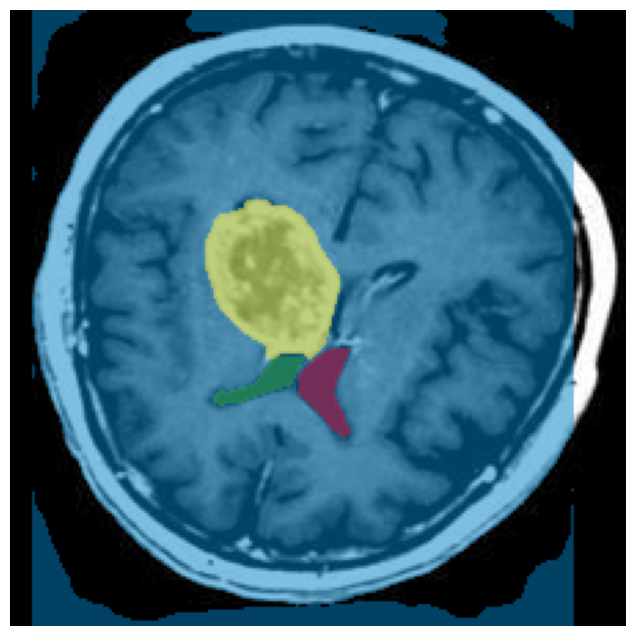

In [52]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [53]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [54]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [77]:
widget.bboxes

[{'x': 64, 'y': 123, 'width': 39, 'height': 21, 'label': ''}]

In [78]:



box = widget.bboxes[0] if widget.bboxes else default_box
box = [
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
]
print(box)

[64, 123, 103, 144]


In [79]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.7,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.box_prompt(bbox=box)


image 1/1 /content/CsiLab-BrainTumor-3/train/45_jpg.rf.36ef270424c1c2114e972a731368c5df.jpg: 1024x1024 2 objects, 160.3ms
Speed: 5.7ms preprocess, 160.3ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)


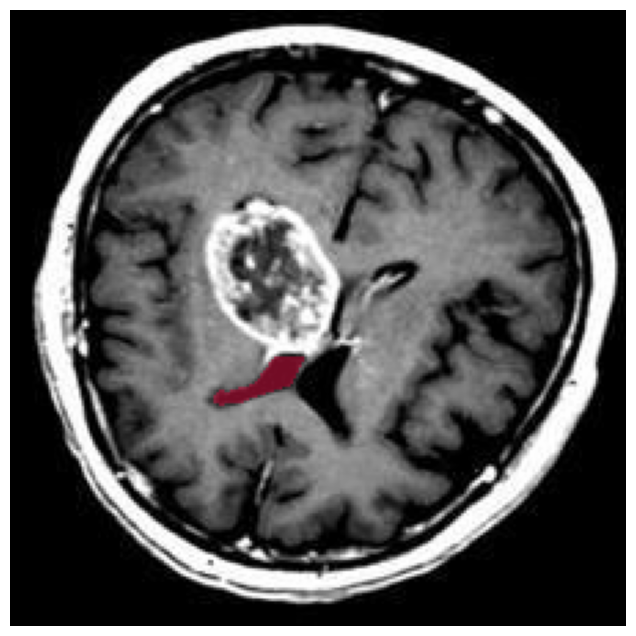

In [80]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [71]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.9)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()


image 1/1 /content/CsiLab-BrainTumor-3/train/45_jpg.rf.36ef270424c1c2114e972a731368c5df.jpg: 1024x1024 4 objects, 162.0ms
Speed: 4.5ms preprocess, 162.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)


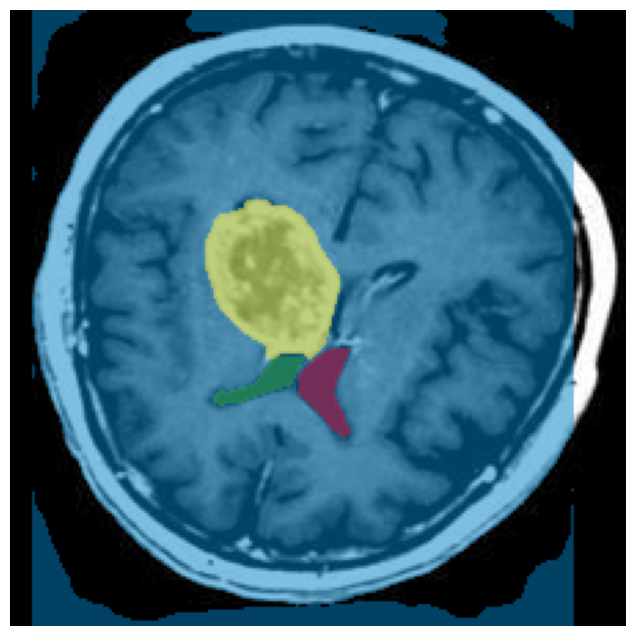

In [72]:
masks = masks.cpu().numpy().astype(bool)

annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [81]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.9)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='tumor')


image 1/1 /content/CsiLab-BrainTumor-3/train/45_jpg.rf.36ef270424c1c2114e972a731368c5df.jpg: 1024x1024 4 objects, 158.9ms
Speed: 6.8ms preprocess, 158.9ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)


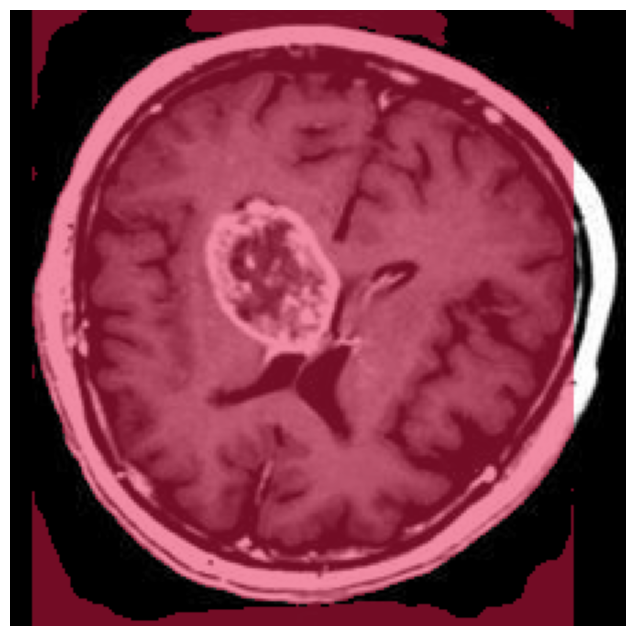

In [82]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))